In [1]:
#pip install dbfread

In [2]:
import pandas as pd
from dbfread import DBF
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Configuración vara visualizar todas las columnas
#pd.set_option('display.max_columns', None)

## Dataset de percepción de la seguridad en México y en Jalisco

Enlace donde se obtuvieron los archivos: https://www.inegi.org.mx/programas/ensu/#datos_abiertos

Como referente de la inseguridad en cada ciudad, se tomó la columna (BP1_1), titulada "Percepción de seguridad en la ciudad en el sitio web", en el diccionario de datos: https://www.inegi.org.mx/rnm/index.php/catalog/859/data-dictionary/F11?file_name=ENSU_CB_0923

### Dataset 1 México

In [4]:
final_dataframe = pd.DataFrame()
directorio_dbf = r'C:\Users\German\Documents\euzen\2_Seguridad_Pública\ensu_bd_2018_2019_2020_dbf'

archivos_dbf = os.listdir(directorio_dbf)
archivos_dbf = [archivo for archivo in archivos_dbf if archivo.endswith('.dbf')]

for archivo in archivos_dbf:
    año = archivo[-6:-4]
    año = '20' + año
    
    # Extraer el mes del nombre del archivo
    mes = archivo[-8:-4]
    mes = mes[-5:-2]  # Tomar los dos últimos dígitos para el mes
    nombre_meses = {
        '01': 'enero', '02': 'febrero', '03': 'marzo',
        '04': 'abril', '05': 'mayo', '06': 'junio',
        '07': 'julio', '08': 'agosto', '09': 'septiembre',
        '10': 'octubre', '11': 'noviembre', '12': 'diciembre'
    }
    nombre_mes = nombre_meses.get(mes, 'desconocido')
    
    ruta_archivo_dbf = os.path.join(directorio_dbf, archivo)
    
    # Leer el archivo DBF
    df_dbf = DBF(ruta_archivo_dbf, encoding='CP1252')
    df_dbf = pd.DataFrame(iter(df_dbf))
    
    df_dbf['Año'] = año
    df_dbf['Mes'] = nombre_mes  # Agregar columna de Mes
    final_dataframe = pd.concat([final_dataframe, df_dbf])


In [5]:
df1 = DBF(r'C:\Users\German\Documents\euzen\2_Seguridad_Pública\ensu_bd_2018_2019_2020_dbf\Especiales\ENSU_CB_sec1_2_3_0920.dbf', encoding='CP1252')
df2 = DBF(r'C:\Users\German\Documents\euzen\2_Seguridad_Pública\ensu_bd_2018_2019_2020_dbf\Especiales\ENSU_CB_sec4_0920.dbf', encoding='CP1252')

df1 = pd.DataFrame(iter(df1))
df2 = pd.DataFrame(iter(df2))

concatenated_df = pd.concat([df1, df2], ignore_index=True)

concatenated_df['Año'] = '2020'  # Añadir el valor del año que corresponda
concatenated_df['Mes'] = 'septiembre'  # Añadir el nombre del mes que corresponda

concatenated_df = concatenated_df.drop_duplicates(subset=['ID_VIV'], keep='first')

In [6]:
# Concatenar concatenated_df con final_dataframe

merged_dataframe = pd.concat([final_dataframe, concatenated_df], ignore_index=True)

In [7]:
# Se limpia el dataset combinado

columnas = ['Año', 'Mes', 'NOM_ENT', 'BP1_1']
merged_dataframe = merged_dataframe[columnas]

merged_dataframe['NOM_ENT'] = merged_dataframe['NOM_ENT'].str.replace(r'\r$', '', regex=True)
merged_dataframe['NOM_ENT'] = merged_dataframe['NOM_ENT'].str.title()
merged_dataframe['NOM_ENT'] = merged_dataframe['NOM_ENT'].replace('Mexico', 'Estado De Mexico')

merged_dataframe = merged_dataframe.sort_values(by=['Año', 'Mes'])

merged_dataframe.reset_index(inplace=True, drop=True)

merged_dataframe['BP1_1'] = merged_dataframe['BP1_1'].astype(float)

In [8]:
# Se crean columnas dummies a partir de la percepción de la inseguridad

columns_to_dummify = merged_dataframe.filter(regex='^BP1').columns

df_dummies = merged_dataframe.copy()

for column in columns_to_dummify:
    dummies_inseguro = pd.get_dummies(merged_dataframe[column].apply(lambda x: 1 if x == 2 else 0), prefix=column + '_INSEGURO', drop_first=True)
    dummies_seguro = pd.get_dummies(merged_dataframe[column].apply(lambda x: 1 if x == 1 else 0), prefix=column + '_SEGURO', drop_first=True)

    df_dummies = pd.concat([df_dummies, dummies_inseguro, dummies_seguro], axis=1)

In [9]:
# Se agrupan las columnas dummies por año y luego por mes, después se suman en otra columna y luego se saca el porcentaje de seguridad del total

columns_to_sum = [col for col in df_dummies.columns if '_INSEGURO_1' in col or '_SEGURO_1' in col]
df_agru_mex = df_dummies.groupby(['Año', 'Mes']).agg({col: 'sum' for col in columns_to_sum}).reset_index()
df_agru_mex['BP1_1_TOTAL'] = df_agru_mex['BP1_1_INSEGURO_1'] + df_agru_mex['BP1_1_SEGURO_1']
df_agru_mex['PORCENTAJE_BP1_1_SEGURO_1'] = (df_agru_mex['BP1_1_SEGURO_1'] / df_agru_mex['BP1_1_TOTAL']) * 100


In [10]:
# Se renombra para identificar el dataset

df_mex_18_20 = df_agru_mex

In [11]:
# Se le añade el trimestre faltante con base en los datos de los otros meses

media_inseguro = int((12551 + 13157) / 2)
media_seguro = int((4955 + 5813) / 2)

junio_2020_estimado = {
    'Año': 2020,
    'Mes': 'junio',
    'BP1_1_INSEGURO_1': media_inseguro,
    'BP1_1_SEGURO_1': media_seguro,
    'BP1_1_TOTAL': media_inseguro + media_seguro,
    'PORCENTAJE_BP1_1_SEGURO_1': ((media_seguro / (media_inseguro + media_seguro)) * 100)
}

df_mex_18_20 = df_mex_18_20.append(junio_2020_estimado, ignore_index=True)

df_mex_18_20['PORCENTAJE_BP1_1_SEGURO_1'] = df_mex_18_20['PORCENTAJE_BP1_1_SEGURO_1'].round(2)

In [12]:
# Dataset resultante

df_mex_18_20

,Año,Mes,BP1_1_INSEGURO_1,BP1_1_SEGURO_1,BP1_1_TOTAL,PORCENTAJE_BP1_1_SEGURO_1
0,2018,diciembre,12520.0,5442.0,17962.0,30.30
1,2018,junio,12551.0,4955.0,17506.0,28.30
2,2018,marzo,11179.0,3967.0,15146.0,26.19
3,2018,septiembre,14379.0,5705.0,20084.0,28.41
4,2019,diciembre,15378.0,6707.0,22085.0,30.37
5,2019,junio,13157.0,5813.0,18970.0,30.64
6,2019,marzo,12824.0,5240.0,18064.0,29.01
7,2019,septiembre,15168.0,7170.0,22338.0,32.10
8,2020,diciembre,14228.0,7971.0,22199.0,35.91
9,2020,marzo,15526.0,6789.0,22315.0,30.42


### Graficamos la percepción de inseguridad de México 2018-2020

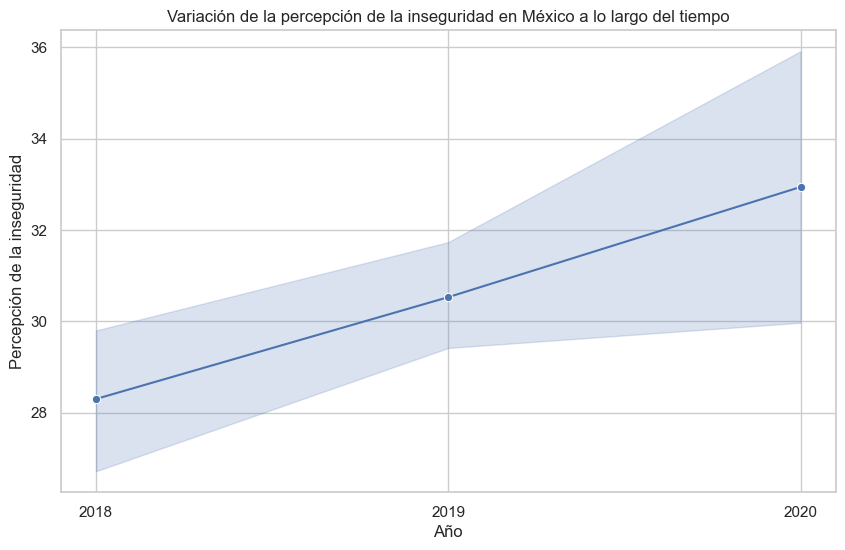

In [13]:
df_mex_18_20['Año'] = df_mex_18_20['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_mex_18_20, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')
plt.show()

### Dataset 1 Jalisco

In [14]:
df_dummies_jal = df_dummies[df_dummies['NOM_ENT'] == 'Jalisco']

# Se agrupan las columnas dummies por año y luego por mes, después se suman en otra columna y luego se saca el porcentaje de seguridad del total

columns_to_sum = [col for col in df_dummies.columns if '_INSEGURO_1' in col or '_SEGURO_1' in col]
df_agru_jal = df_dummies_jal.groupby(['Año', 'Mes']).agg({col: 'sum' for col in columns_to_sum}).reset_index()
df_agru_jal['BP1_1_TOTAL'] = df_agru_jal['BP1_1_INSEGURO_1'] + df_agru_jal['BP1_1_SEGURO_1']
df_agru_jal['PORCENTAJE_BP1_1_SEGURO_1'] = (df_agru_jal['BP1_1_SEGURO_1'] / df_agru_jal['BP1_1_TOTAL']) * 100

# Se renombra para identificar el dataset

df_jal_18_20 = df_agru_jal


# Se le añade el trimestre faltante con base en los datos de los otros meses

media_inseguro = int((1102.0 + 1076.0) / 2)
media_seguro = int((457.0 + 482.0) / 2)

junio_2020_estimado = {
    'Año': 2020,
    'Mes': 'junio',
    'BP1_1_INSEGURO_1': media_inseguro,
    'BP1_1_SEGURO_1': media_seguro,
    'BP1_1_TOTAL': media_inseguro + media_seguro,
    'PORCENTAJE_BP1_1_SEGURO_1': ((media_seguro / (media_inseguro + media_seguro)) * 100)
}

df_jal_18_20 = df_jal_18_20.append(junio_2020_estimado, ignore_index=True)

df_jal_18_20['PORCENTAJE_BP1_1_SEGURO_1'] = df_jal_18_20['PORCENTAJE_BP1_1_SEGURO_1'].round(2)

In [15]:
# Dataset resultante

df_jal_18_20

,Año,Mes,BP1_1_INSEGURO_1,BP1_1_SEGURO_1,BP1_1_TOTAL,PORCENTAJE_BP1_1_SEGURO_1
0,2018,diciembre,1051.0,470.0,1521.0,30.90
1,2018,junio,1102.0,457.0,1559.0,29.31
2,2018,marzo,321.0,216.0,537.0,40.22
3,2018,septiembre,1064.0,469.0,1533.0,30.59
4,2019,diciembre,1066.0,466.0,1532.0,30.42
5,2019,junio,1076.0,482.0,1558.0,30.94
6,2019,marzo,1158.0,402.0,1560.0,25.77
7,2019,septiembre,1078.0,493.0,1571.0,31.38
8,2020,diciembre,1028.0,549.0,1577.0,34.81
9,2020,marzo,1077.0,473.0,1550.0,30.52


### Graficamos la percepción de inseguridad de Jalisco 2018-2020

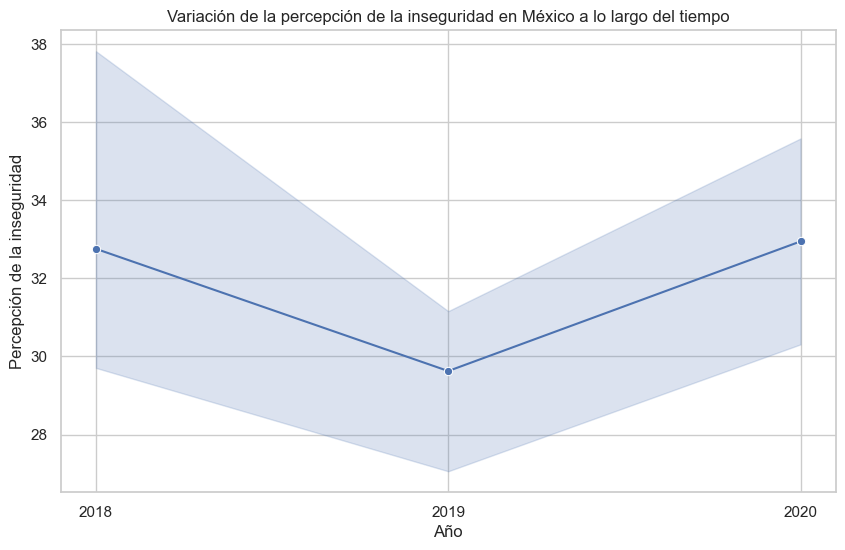

In [16]:
df_jal_18_20['Año'] = df_jal_18_20['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_jal_18_20, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')
plt.show()

---

---

### Dataset 2 México

In [17]:
final_dataframe = pd.DataFrame()
directorio = r'C:\Users\German\Documents\euzen\2_Seguridad_Pública\ensu_bd_2021_2022_2023_csv'

archivos = os.listdir(directorio)
archivos_csv = [archivo for archivo in archivos if archivo.startswith('ENSU_CB_') and archivo.endswith('.csv')]

for archivo in archivos_csv:
    año = archivo[-6:-4]
    año = '20' + año
    
    # Extraer el mes del nombre del archivo
    mes = archivo[-8:-4]
    mes = mes[-5:-2]  # Tomar los dos últimos dígitos para el mes
    nombre_meses = {
        '01': 'enero', '02': 'febrero', '03': 'marzo',
        '04': 'abril', '05': 'mayo', '06': 'junio',
        '07': 'julio', '08': 'agosto', '09': 'septiembre',
        '10': 'octubre', '11': 'noviembre', '12': 'diciembre'
    }
    nombre_mes = nombre_meses.get(mes, 'desconocido')
    
    ruta_archivo = os.path.join(directorio, archivo)
    
    # Intenta leer el archivo con diferentes codificaciones y elimina los retornos de carro
    try:
        df = pd.read_csv(ruta_archivo, encoding='utf-8', lineterminator='\r')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(ruta_archivo, encoding='latin-1', lineterminator='\r')
        except UnicodeDecodeError:
            df = pd.read_csv(ruta_archivo, encoding='utf-16', lineterminator='\r')
    
    df['Año'] = año
    df['Mes'] = nombre_mes  # Agregar columna de Mes
    final_dataframe = pd.concat([final_dataframe, df])

In [18]:
# Se limpia el dataset combinado

columnas = ['Año', 'Mes', 'NOM_ENT', 'BP1_1']
final_dataframe = final_dataframe[columnas]

final_dataframe['NOM_ENT'] = final_dataframe['NOM_ENT'].str.replace(r'\r$', '', regex=True)
final_dataframe['NOM_ENT'] = final_dataframe['NOM_ENT'].str.title()
final_dataframe['NOM_ENT'] = final_dataframe['NOM_ENT'].replace('Mexico', 'Estado De Mexico')

final_dataframe = final_dataframe.sort_values(by=['Año', 'Mes'])

final_dataframe.reset_index(inplace=True, drop=True)

final_dataframe['BP1_1'] = final_dataframe['BP1_1'].astype(float)

In [19]:
# Se crean columnas dummies a partir de la percepción de la inseguridad

columns_to_dummify = final_dataframe.filter(regex='^BP1').columns

df_dummies = final_dataframe.copy()

for column in columns_to_dummify:
    dummies_inseguro = pd.get_dummies(final_dataframe[column].apply(lambda x: 1 if x == 2 else 0), prefix=column + '_INSEGURO', drop_first=True)
    dummies_seguro = pd.get_dummies(final_dataframe[column].apply(lambda x: 1 if x == 1 else 0), prefix=column + '_SEGURO', drop_first=True)
    
    df_dummies = pd.concat([df_dummies, dummies_inseguro, dummies_seguro], axis=1)

In [20]:
# Se agrupan las columnas dummies por año y luego por mes, después se suman en otra columna y luego se saca el porcentaje de seguridad del total

columns_to_sum = [col for col in df_dummies.columns if '_INSEGURO_1' in col or '_SEGURO_1' in col]
df_agru_mex = df_dummies.groupby(['Año', 'Mes']).agg({col: 'sum' for col in columns_to_sum}).reset_index()
df_agru_mex['BP1_1_TOTAL'] = df_agru_mex['BP1_1_INSEGURO_1'] + df_agru_mex['BP1_1_SEGURO_1']
df_agru_mex['PORCENTAJE_BP1_1_SEGURO_1'] = (df_agru_mex['BP1_1_SEGURO_1'] / df_agru_mex['BP1_1_TOTAL']) * 100
df_agru_mex['PORCENTAJE_BP1_1_SEGURO_1'] = df_agru_mex['PORCENTAJE_BP1_1_SEGURO_1'].round(2)


# Se le añade el mes faltante con base en los datos de los otros meses, para que no se descompense por la falta de información aunque sea solo un estimado

media_inseguro = int((14622 + 14689) / 2)
media_seguro = int((8736 + 9618) / 2)

diciembre_2023_estimado = {
    'Año': 2023,
    'Mes': 'diciembre',
    'BP1_1_INSEGURO_1': media_inseguro,
    'BP1_1_SEGURO_1': media_seguro,
    'BP1_1_TOTAL': media_inseguro + media_seguro,
    'PORCENTAJE_BP1_1_SEGURO_1': ((media_seguro / (media_inseguro + media_seguro)) * 100)
}

df_agru_mex = df_agru_mex.append(diciembre_2023_estimado, ignore_index=True)

df_mex_21_23 = df_agru_mex


In [21]:
df_mex_21_23

,Año,Mes,BP1_1_INSEGURO_1,BP1_1_SEGURO_1,BP1_1_TOTAL,PORCENTAJE_BP1_1_SEGURO_1
0,2021,diciembre,14622.0,8736.0,23358.0,37.400000
1,2021,junio,13901.0,8438.0,22339.0,37.770000
2,2021,marzo,13776.0,8430.0,22206.0,37.960000
3,2021,septiembre,14392.0,8892.0,23284.0,38.190000
4,2022,diciembre,14689.0,9618.0,24307.0,39.570000
5,2022,junio,15178.0,8464.0,23642.0,35.800000
6,2022,marzo,14757.0,8770.0,23527.0,37.280000
7,2022,septiembre,14353.0,9182.0,23535.0,39.010000
8,2023,junio,14471.0,9896.0,24367.0,40.610000
9,2023,marzo,14024.0,9682.0,23706.0,40.840000


In [22]:
# Se renombra para identificar el dataset

df_mex_21_23 = df_agru_mex

In [23]:
# Dataset resultante

df_mex_21_23

,Año,Mes,BP1_1_INSEGURO_1,BP1_1_SEGURO_1,BP1_1_TOTAL,PORCENTAJE_BP1_1_SEGURO_1
0,2021,diciembre,14622.0,8736.0,23358.0,37.400000
1,2021,junio,13901.0,8438.0,22339.0,37.770000
2,2021,marzo,13776.0,8430.0,22206.0,37.960000
3,2021,septiembre,14392.0,8892.0,23284.0,38.190000
4,2022,diciembre,14689.0,9618.0,24307.0,39.570000
5,2022,junio,15178.0,8464.0,23642.0,35.800000
6,2022,marzo,14757.0,8770.0,23527.0,37.280000
7,2022,septiembre,14353.0,9182.0,23535.0,39.010000
8,2023,junio,14471.0,9896.0,24367.0,40.610000
9,2023,marzo,14024.0,9682.0,23706.0,40.840000


### Graficamos la percepción de inseguridad de Jalisco 2021-2023

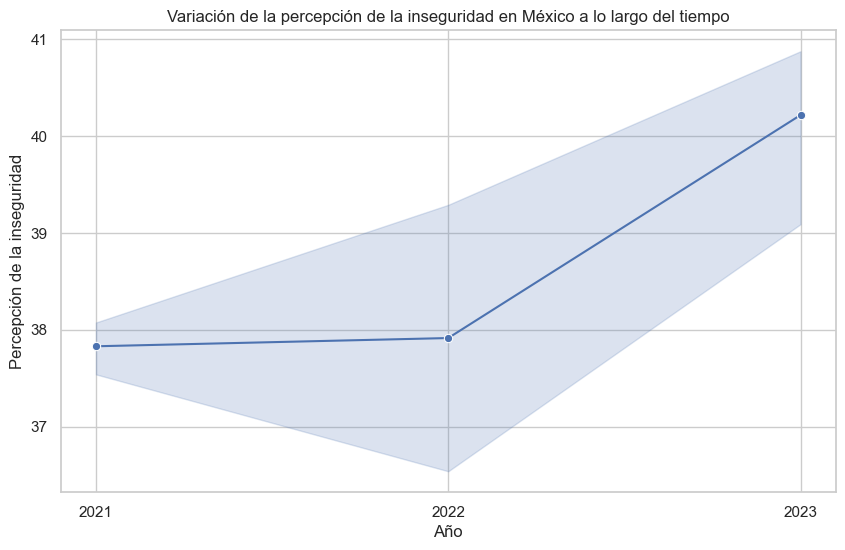

In [24]:
df_mex_21_23['Año'] = df_mex_21_23['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_mex_21_23, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')
plt.show()

### Dataset 2 Jalisco

In [25]:
# Se filtra por estado

df_dummies_jal = df_dummies[df_dummies['NOM_ENT'] == 'Jalisco']

# Se agrupan las columnas dummies por año y luego por mes, después se suman en otra columna y luego se saca el porcentaje de seguridad del total

columns_to_sum = [col for col in df_dummies.columns if '_INSEGURO_1' in col or '_SEGURO_1' in col]
df_agru_jal = df_dummies_jal.groupby(['Año', 'Mes']).agg({col: 'sum' for col in columns_to_sum}).reset_index()
df_agru_jal['BP1_1_TOTAL'] = df_agru_jal['BP1_1_INSEGURO_1'] + df_agru_jal['BP1_1_SEGURO_1']
df_agru_jal['PORCENTAJE_BP1_1_SEGURO_1'] = (df_agru_jal['BP1_1_SEGURO_1'] / df_agru_jal['BP1_1_TOTAL']) * 100
df_agru_jal['PORCENTAJE_BP1_1_SEGURO_1'] = df_agru_jal['PORCENTAJE_BP1_1_SEGURO_1'].round(2)


# Se le añade el mes faltante con base en los datos de los otros meses, para que no se descompense por la falta de información aunque sea solo un estimado

media_inseguro = int((1021	 + 1003) / 2)
media_seguro = int((1003 + 519) / 2)

diciembre_2023_estimado = {
    'Año': 2023,
    'Mes': 'diciembre',
    'BP1_1_INSEGURO_1': media_inseguro,
    'BP1_1_SEGURO_1': media_seguro,
    'BP1_1_TOTAL': media_inseguro + media_seguro,
    'PORCENTAJE_BP1_1_SEGURO_1': ((media_seguro / (media_inseguro + media_seguro)) * 100)
}

df_agru_jal = df_agru_jal.append(diciembre_2023_estimado, ignore_index=True)


# Se renombra para identificar el dataset

df_jal_21_23 = df_agru_jal

In [26]:
df_jal_21_23

,Año,Mes,BP1_1_INSEGURO_1,BP1_1_SEGURO_1,BP1_1_TOTAL,PORCENTAJE_BP1_1_SEGURO_1
0,2021,diciembre,1021.0,530.0,1551.0,34.170000
1,2021,junio,1090.0,460.0,1550.0,29.680000
2,2021,marzo,1064.0,514.0,1578.0,32.570000
3,2021,septiembre,948.0,583.0,1531.0,38.080000
4,2022,diciembre,1003.0,519.0,1522.0,34.100000
5,2022,junio,991.0,553.0,1544.0,35.820000
6,2022,marzo,996.0,548.0,1544.0,35.490000
7,2022,septiembre,989.0,541.0,1530.0,35.360000
8,2023,junio,1456.0,690.0,2146.0,32.150000
9,2023,marzo,950.0,579.0,1529.0,37.870000


### Graficamos la percepción de inseguridad de Jalisco 2021-2023

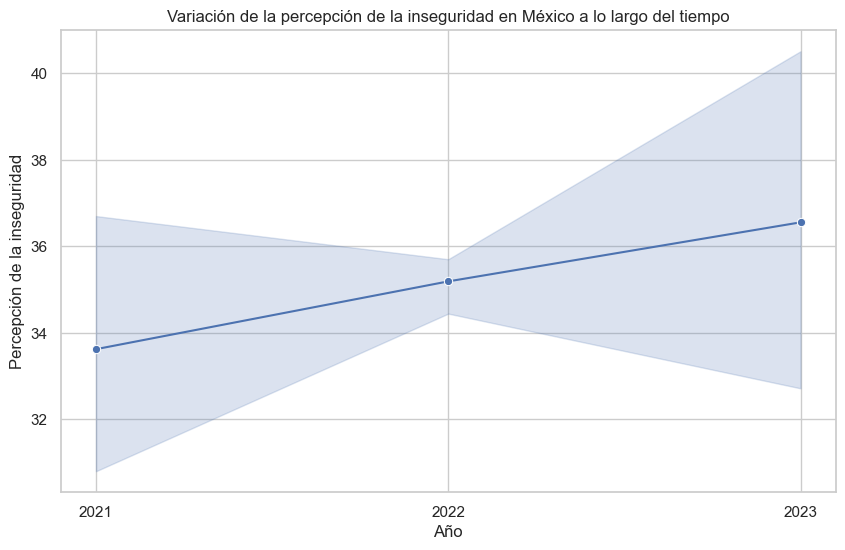

In [27]:
df_jal_21_23['Año'] = df_jal_21_23['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_jal_21_23, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')
plt.show()

---

----

### Concatenamos los dos datasets

In [28]:
df_percepcion_mex = pd.concat([df_mex_18_20, df_mex_21_23])
df_percepcion_jal = pd.concat([df_jal_18_20, df_jal_21_23])

### Guardamos los datasets

In [29]:
df_percepcion_mex.to_csv("df_percepcion_mex.csv", index=False)
df_percepcion_jal.to_csv("df_percepcion_jal.csv", index=False)

---

---

### Graficamos la percpeción de la inseguridad 2018-2023

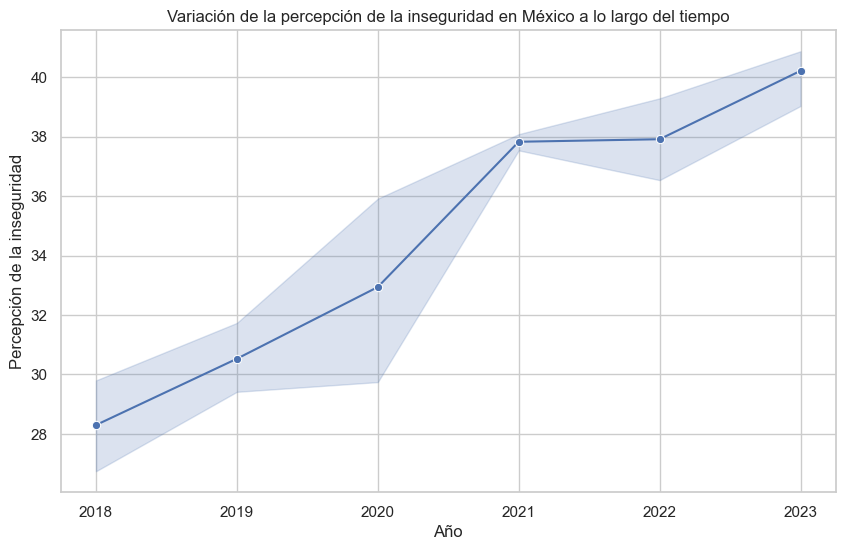

In [30]:
# Variación de la percepción de la inseguridad en México a lo largo del tiempo

df_percepcion_mex['Año'] = df_percepcion_mex['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_percepcion_mex, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')
plt.show()


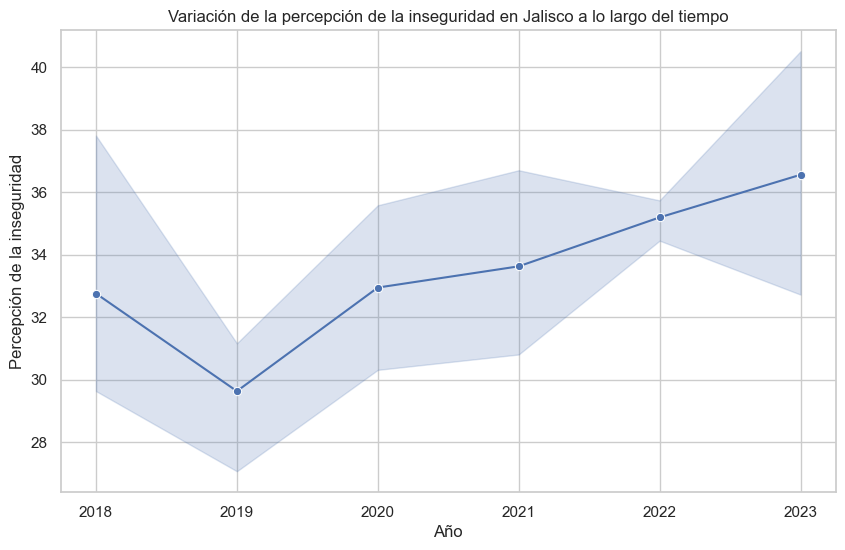

In [31]:
# Variación de la percepción de la inseguridad en Jalisco a lo largo del tiempo

df_percepcion_jal['Año'] = df_percepcion_jal['Año'].astype(str)

# Establecer el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Graficar con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_percepcion_jal, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o')
plt.xlabel('Año')
plt.ylabel('Percepción de la inseguridad')
plt.title('Variación de la percepción de la inseguridad en Jalisco a lo largo del tiempo')
plt.show()

---

---

### Dataset de crímenes en México y en Jalisco

Enlace donde se obtuvo el archivo: https://www.gob.mx/sesnsp/acciones-y-programas/datos-abiertos-de-incidencia-delictiva?state=published donde se obtuvo el siguiente link: https://drive.google.com/file/d/1PslWCPehm2_Z8au2HLeJzc3JCsqrSC7Q/view

In [32]:
df_crimenes = pd.read_csv("IDEFC_NM_oct23.csv", encoding='latin-1')

In [34]:
df_crimenes_mexico = df_crimenes.groupby(['Año'])[['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']].sum()
df_crimenes_mexico.reset_index(inplace=True)
valor_estimado_noviembre = df_crimenes_mexico.loc[8, 'Octubre'] * 0.8
valor_estimado_diciembre = df_crimenes_mexico.loc[8, 'Octubre'] * 0.8
df_crimenes_mexico.at[8, 'Noviembre'] = valor_estimado_noviembre
df_crimenes_mexico.at[8, 'Diciembre'] = valor_estimado_diciembre
df_crimenes_mexico['Total del año'] = df_crimenes_mexico.sum(axis=1)


df_crimenes_entidad = df_crimenes.groupby(['Año', 'Entidad'])[['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']].sum()
df_crimenes_jalisco = df_crimenes_entidad[df_crimenes_entidad.index.get_level_values('Entidad') == 'Jalisco']
df_crimenes_jalisco.reset_index(inplace=True)
valor_estimado_noviembre = df_crimenes_jalisco.loc[8, 'Octubre'] * 0.8
valor_estimado_diciembre = df_crimenes_jalisco.loc[8, 'Octubre'] * 0.8
df_crimenes_jalisco.at[8, 'Noviembre'] = valor_estimado_noviembre
df_crimenes_jalisco.at[8, 'Diciembre'] = valor_estimado_diciembre
df_crimenes_jalisco['Total del año'] = df_crimenes_jalisco.sum(axis=1)


In [35]:
#Guardamos los datasets

#df_crimenes_mexico.to_csv("df_crimenes_mexico.csv", index=False)
#df_crimenes_jalisco.to_csv("df_crimenes_jalisco.csv", index=False)

### Graficamos la cantidad de crímenes, primero en México

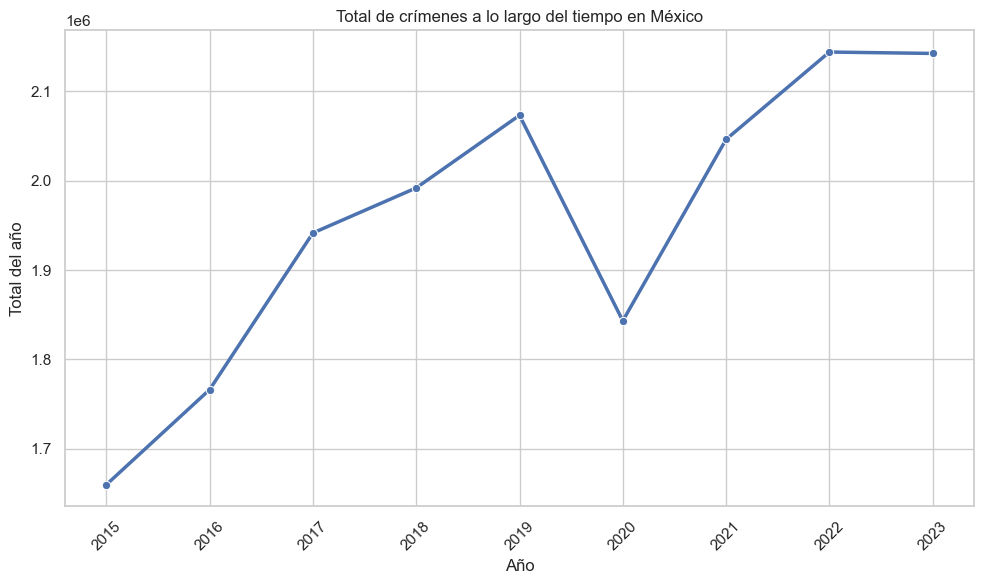

In [44]:
# Variación de la percepción de la inseguridad en Jalisco a lo largo del tiempo

df_crimenes_mexico['Año'] = df_crimenes_mexico['Año'].astype(str)

sns.set(style="whitegrid")

# Graficar usando Matplotlib y Seaborn
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la figura

# Usar Seaborn para trazar la línea
sns.lineplot(x='Año', y='Total del año', data=df_crimenes_mexico, marker='o', color='b', linewidth=2.5)

# Configuración adicional
plt.title('Total de crímenes a lo largo del tiempo en México')
plt.xlabel('Año')
plt.ylabel('Total del año')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visualización
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### Graficamos la cantidad de crímenes, ahora en Jalisco

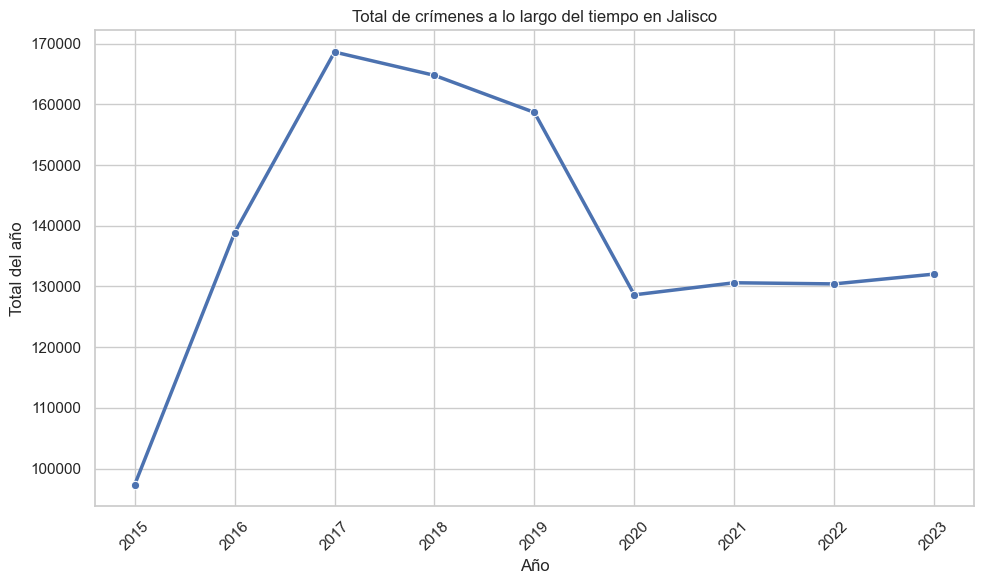

In [59]:
# Variación de la percepción de la inseguridad en Jalisco a lo largo del tiempo

df_crimenes_jalisco['Año'] = df_crimenes_jalisco['Año'].astype(str)

sns.set(style="whitegrid")

# Graficar usando Matplotlib y Seaborn
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la figura

# Usar Seaborn para trazar la línea
sns.lineplot(x='Año', y='Total del año', data=df_crimenes_jalisco, marker='o', color='b', linewidth=2.5)

# Configuración adicional
plt.title('Total de crímenes a lo largo del tiempo en Jalisco')
plt.xlabel('Año')
plt.ylabel('Total del año')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visualización
plt.tight_layout()

# Mostrar la gráfica
plt.show()

---

---

# Comparamos las tablas de percepción y de crímenes  a lo largo del tiempo, primero de México

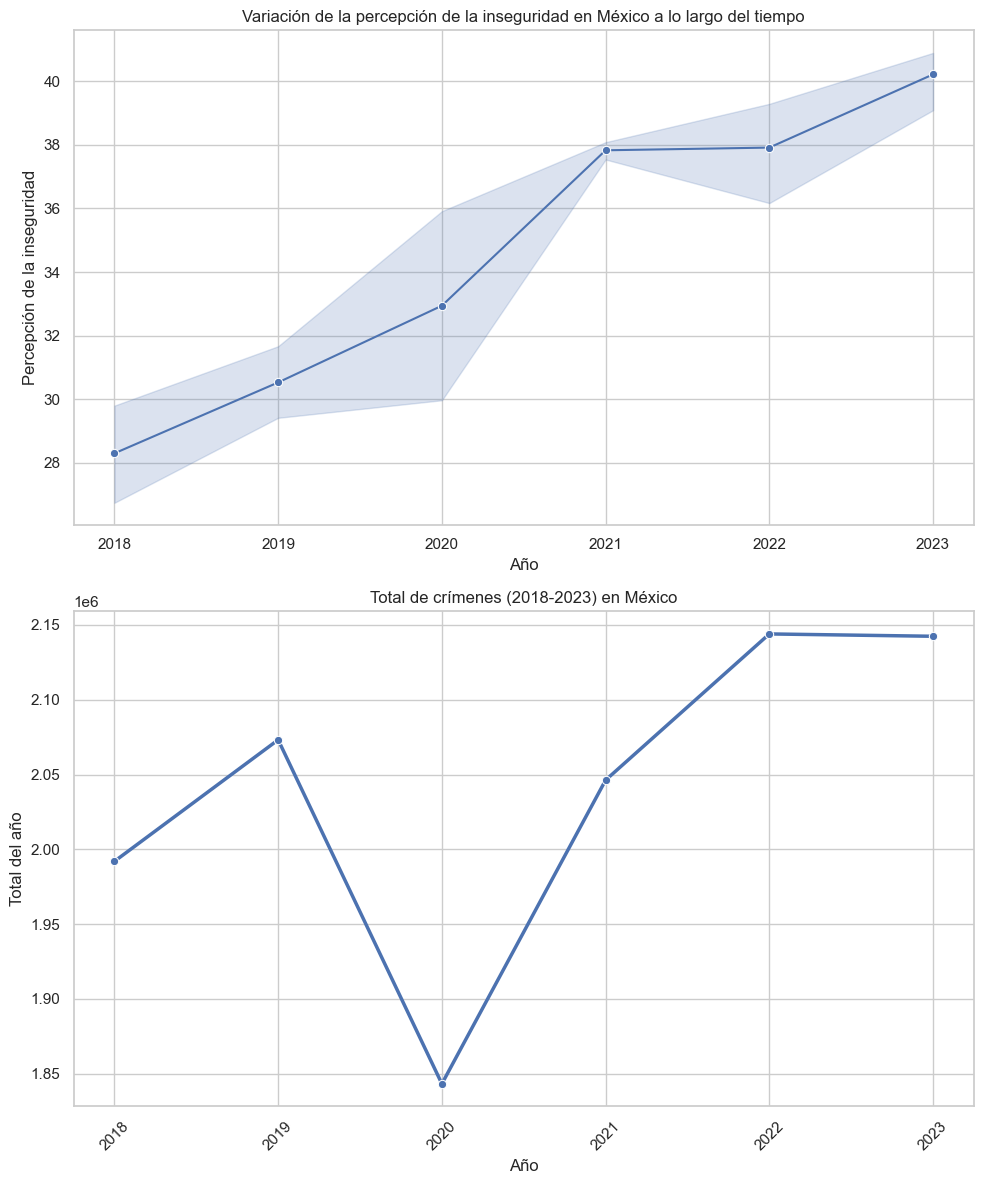

In [53]:
df_crimenes_mexico_filtrado = df_crimenes_mexico[df_crimenes_mexico['Año'].between('2018', '2023')]


df_percepcion_mex['Año'] = df_percepcion_mex['Año'].astype(str)
df_crimenes_mexico_filtrado['Año'] = df_crimenes_mexico_filtrado['Año'].astype(str)

sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

sns.lineplot(data=df_percepcion_mex, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o', ax=ax1)
ax1.set_xlabel('Año')
ax1.set_ylabel('Percepción de la inseguridad')
ax1.set_title('Variación de la percepción de la inseguridad en México a lo largo del tiempo')

sns.lineplot(x='Año', y='Total del año', data=df_crimenes_mexico_filtrado, marker='o', color='b', linewidth=2.5, ax=ax2)
ax2.set_xlabel('Año')
ax2.set_ylabel('Total del año')
ax2.set_title('Total de crímenes (2018-2023) en México')
ax2.tick_params(axis='x', rotation=45) 

plt.tight_layout()

plt.show()

# Comparamos las tablas de percepción y de crímenes  a lo largo del tiempo, ahora de Jalisco

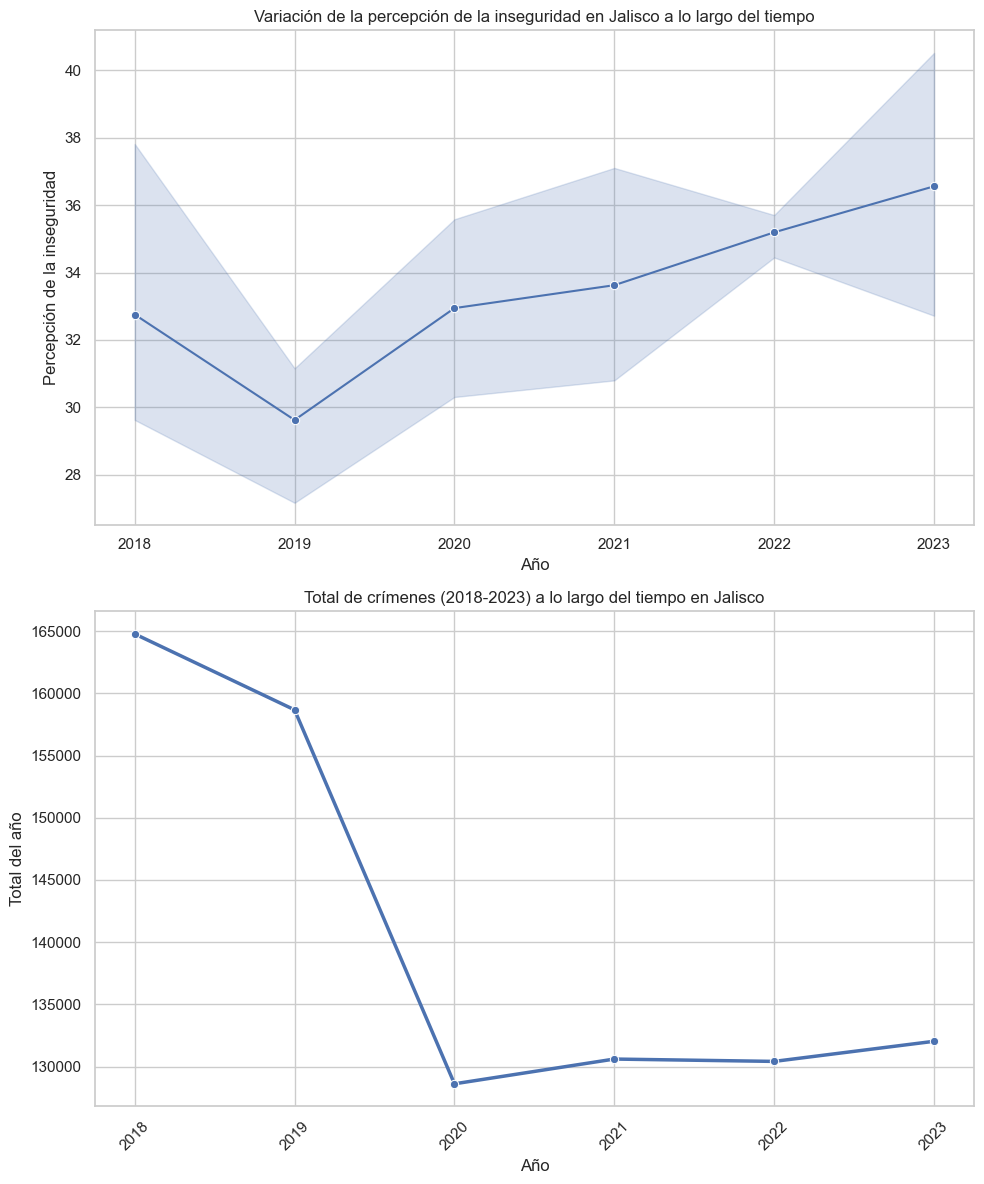

In [54]:
df_crimenes_jalisco_filtrado = df_crimenes_jalisco[df_crimenes_jalisco['Año'].between('2018', '2023')]

df_percepcion_jal['Año'] = df_percepcion_jal['Año'].astype(str)
df_crimenes_jalisco_filtrado['Año'] = df_crimenes_jalisco_filtrado['Año'].astype(str)

sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

sns.lineplot(data=df_percepcion_jal, x='Año', y='PORCENTAJE_BP1_1_SEGURO_1', marker='o', ax=ax1)
ax1.set_xlabel('Año')
ax1.set_ylabel('Percepción de la inseguridad')
ax1.set_title('Variación de la percepción de la inseguridad en Jalisco a lo largo del tiempo')

sns.lineplot(x='Año', y='Total del año', data=df_crimenes_jalisco_filtrado, marker='o', color='b', linewidth=2.5, ax=ax2)
ax2.set_xlabel('Año')
ax2.set_ylabel('Total del año')
ax2.set_title('Total de crímenes (2018-2023) a lo largo del tiempo en Jalisco')
ax2.tick_params(axis='x', rotation=45)  

plt.tight_layout()

plt.show()